In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

In [12]:
np.max(np.abs(syscov - np.diag(syscov))), np.max(np.abs(np.diag(syscov)))

(0.03899650969, 0.02815552265)

In [13]:
np.min(np.abs(syscov)), np.min(np.abs(np.diag(syscov)))

(1.695011341e-07, 0.001006144079)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [22]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * syscov * err
    covset_noise[i] = syscov + 0.05 * syscov * err
   # covset_noise[i] = syscov + 0.001*err

 Generating 2345 matrix 

 Generating 4582 matrix 

 Generating 6832 matrix 

 Generating 9120 matrix 

 Generating 10000 matrix 

(10000, 31, 31)


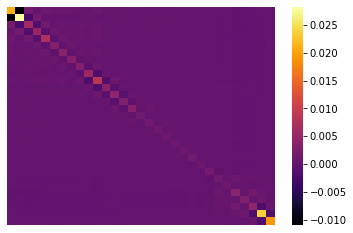

In [23]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [24]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)                0     

In [25]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [26]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
250/250 [==============================] - 1s 3ms/step - loss: 8.4914e-07 - val_loss: 4.5653e-09
Epoch 2/500
250/250 [==============================] - 0s 1ms/step - loss: 1.5947e-08 - val_loss: 1.2327e-08
Epoch 3/500
250/250 [==============================] - 0s 1ms/step - loss: 2.4083e-08 - val_loss: 1.1074e-08
Epoch 4/500
250/250 [==============================] - 0s 1ms/step - loss: 2.6447e-08 - val_loss: 3.7882e-08
Epoch 5/500
250/250 [==============================] - 0s 1ms/step - loss: 3.7633e-08 - val_loss: 9.6840e-09
Epoch 6/500
250/250 [==============================] - 0s 1ms/step - loss: 2.4135e-08 - val_loss: 1.6660e-08
Epoch 7/500
250/250 [==============================] - 0s 1ms/step - loss: 2.8722e-08 - val_loss: 8.0629e-09
Epoch 8/500
250/250 [==============================] - 0s 1ms/step - loss: 2.8694e-08 - val_loss: 9.6485e-09
Epoch 9/500
250/250 [==============================] - 0s 1ms/step - loss: 1.4198e-08 - val_loss: 2.6763e-08
Epoch 10/500
250/25

250/250 [==============================] - 0s 1ms/step - loss: 8.9254e-09 - val_loss: 3.0802e-09
Epoch 76/500
250/250 [==============================] - 0s 1ms/step - loss: 7.2761e-09 - val_loss: 4.0635e-09
Epoch 77/500
250/250 [==============================] - 0s 1ms/step - loss: 1.3706e-08 - val_loss: 5.1801e-09
Epoch 78/500
250/250 [==============================] - 0s 1ms/step - loss: 1.0338e-08 - val_loss: 3.7771e-09
Epoch 79/500
250/250 [==============================] - 0s 1ms/step - loss: 8.0626e-09 - val_loss: 1.6027e-08
Epoch 80/500
250/250 [==============================] - 0s 1ms/step - loss: 1.0580e-08 - val_loss: 5.6792e-09
Epoch 81/500
250/250 [==============================] - 0s 1ms/step - loss: 1.2979e-08 - val_loss: 1.1918e-08
Epoch 82/500
250/250 [==============================] - 0s 1ms/step - loss: 8.8811e-09 - val_loss: 5.6294e-09
Epoch 83/500
250/250 [==============================] - 0s 1ms/step - loss: 9.1492e-09 - val_loss: 6.3270e-09
Epoch 84/500
250/250 [=

250/250 [==============================] - 0s 1ms/step - loss: 6.5252e-09 - val_loss: 5.6277e-09
Epoch 150/500
250/250 [==============================] - 0s 1ms/step - loss: 5.9787e-09 - val_loss: 6.8123e-09
Epoch 151/500
250/250 [==============================] - 0s 1ms/step - loss: 5.7681e-09 - val_loss: 5.7712e-09
Epoch 152/500
250/250 [==============================] - 0s 1ms/step - loss: 8.1067e-09 - val_loss: 4.6534e-09
Epoch 153/500
250/250 [==============================] - 0s 1ms/step - loss: 6.0053e-09 - val_loss: 5.8370e-09
Epoch 154/500
250/250 [==============================] - 0s 1ms/step - loss: 6.9255e-09 - val_loss: 6.1993e-09
Epoch 155/500
250/250 [==============================] - 0s 1ms/step - loss: 6.9649e-09 - val_loss: 2.1390e-09
Epoch 156/500
250/250 [==============================] - 0s 1ms/step - loss: 4.6938e-09 - val_loss: 6.0161e-09
Epoch 157/500
250/250 [==============================] - 0s 1ms/step - loss: 1.2461e-08 - val_loss: 2.4137e-09
Epoch 158/500
2

Epoch 223/500
250/250 [==============================] - 0s 2ms/step - loss: 6.5852e-09 - val_loss: 3.2920e-09
Epoch 224/500
250/250 [==============================] - 0s 2ms/step - loss: 4.4307e-09 - val_loss: 4.6565e-09
Epoch 225/500
250/250 [==============================] - 0s 2ms/step - loss: 5.8541e-09 - val_loss: 4.1760e-09
Epoch 226/500
250/250 [==============================] - 0s 2ms/step - loss: 5.9238e-09 - val_loss: 5.7479e-09
Epoch 227/500
250/250 [==============================] - 0s 2ms/step - loss: 5.9184e-09 - val_loss: 2.2615e-09
Epoch 228/500
250/250 [==============================] - 0s 2ms/step - loss: 4.4910e-09 - val_loss: 4.1801e-09
Epoch 229/500
250/250 [==============================] - 0s 2ms/step - loss: 6.1110e-09 - val_loss: 5.3008e-09
Epoch 230/500
250/250 [==============================] - 0s 2ms/step - loss: 4.7839e-09 - val_loss: 4.4160e-09
Epoch 231/500
250/250 [==============================] - 0s 2ms/step - loss: 9.5492e-09 - val_loss: 3.0550e-09
E

Epoch 297/500
250/250 [==============================] - 0s 1ms/step - loss: 5.3163e-09 - val_loss: 4.4608e-09
Epoch 298/500
250/250 [==============================] - 0s 1ms/step - loss: 5.2456e-09 - val_loss: 3.1479e-09
Epoch 299/500
250/250 [==============================] - 0s 1ms/step - loss: 4.9599e-09 - val_loss: 2.1408e-09
Epoch 300/500
250/250 [==============================] - 0s 1ms/step - loss: 4.5349e-09 - val_loss: 2.0115e-09
Epoch 301/500
250/250 [==============================] - 0s 1ms/step - loss: 3.4247e-09 - val_loss: 1.9833e-09
Epoch 302/500
250/250 [==============================] - 0s 1ms/step - loss: 3.3077e-09 - val_loss: 3.1521e-09
Epoch 303/500
250/250 [==============================] - 0s 1ms/step - loss: 4.7110e-09 - val_loss: 3.2525e-09
Epoch 304/500
250/250 [==============================] - 0s 1ms/step - loss: 4.5858e-09 - val_loss: 2.9660e-09
Epoch 305/500
250/250 [==============================] - 0s 1ms/step - loss: 7.0467e-09 - val_loss: 2.3222e-09
E

Epoch 371/500
250/250 [==============================] - 0s 1ms/step - loss: 3.1234e-09 - val_loss: 1.8301e-09
Epoch 372/500
250/250 [==============================] - 0s 1ms/step - loss: 2.7680e-09 - val_loss: 3.6509e-09
Epoch 373/500
250/250 [==============================] - 0s 1ms/step - loss: 4.9486e-09 - val_loss: 1.5912e-09
Epoch 374/500
250/250 [==============================] - 0s 1ms/step - loss: 4.4069e-09 - val_loss: 3.1835e-09
Epoch 375/500
250/250 [==============================] - 0s 1ms/step - loss: 4.6464e-09 - val_loss: 1.3039e-09
Epoch 376/500
250/250 [==============================] - 0s 1ms/step - loss: 3.1664e-09 - val_loss: 6.3026e-09
Epoch 377/500
250/250 [==============================] - 0s 1ms/step - loss: 5.8165e-09 - val_loss: 1.3313e-09
Epoch 378/500
250/250 [==============================] - 0s 1ms/step - loss: 2.5101e-09 - val_loss: 3.1929e-09
Epoch 379/500
250/250 [==============================] - 0s 1ms/step - loss: 5.5009e-09 - val_loss: 1.2132e-09
E

Epoch 445/500
250/250 [==============================] - 0s 1ms/step - loss: 4.1805e-09 - val_loss: 1.4351e-09
Epoch 446/500
250/250 [==============================] - 0s 1ms/step - loss: 2.4910e-09 - val_loss: 2.5197e-09
Epoch 447/500
250/250 [==============================] - 0s 1ms/step - loss: 5.1401e-09 - val_loss: 6.5517e-10
Epoch 448/500
250/250 [==============================] - 0s 2ms/step - loss: 2.0644e-09 - val_loss: 1.9156e-09
Epoch 449/500
250/250 [==============================] - 0s 1ms/step - loss: 2.8970e-09 - val_loss: 2.2075e-09
Epoch 450/500
250/250 [==============================] - 0s 1ms/step - loss: 3.4381e-09 - val_loss: 1.7596e-09
Epoch 451/500
250/250 [==============================] - 0s 2ms/step - loss: 3.0952e-09 - val_loss: 2.3226e-09
Epoch 452/500
250/250 [==============================] - 0s 2ms/step - loss: 3.2158e-09 - val_loss: 2.2475e-09
Epoch 453/500
250/250 [==============================] - 0s 2ms/step - loss: 4.5259e-09 - val_loss: 4.3343e-09
E

(array([-5.0e-08,  0.0e+00,  5.0e-08,  1.0e-07,  1.5e-07,  2.0e-07,
         2.5e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

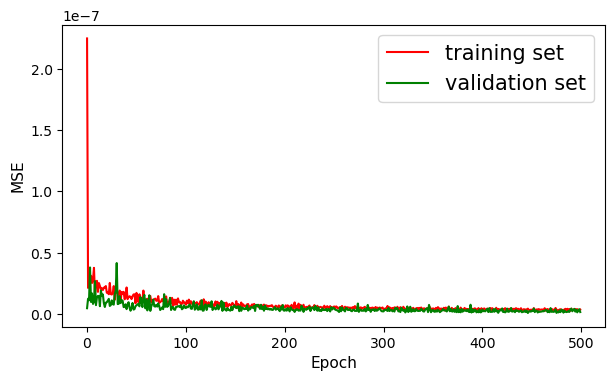

In [27]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [28]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

6.551740261429018e-10 2.2481196904067247e-09


In [29]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(2000, 31)


(2000, 961)


<AxesSubplot:>

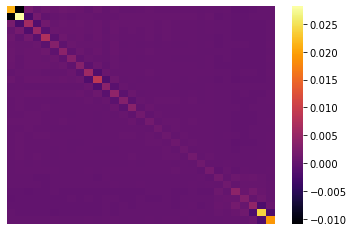

In [30]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


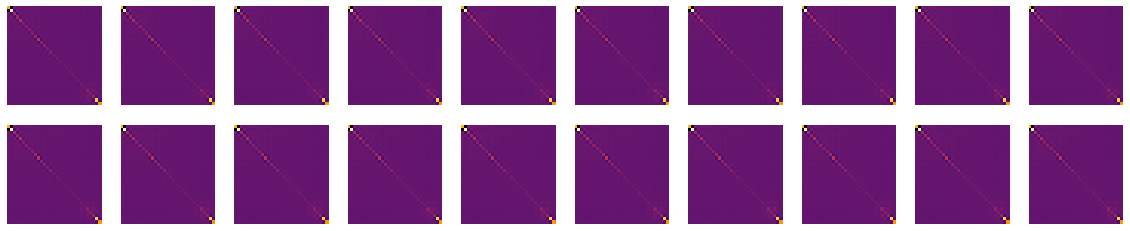

In [31]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [32]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [33]:
fake_encoded = np.zeros((1, 31))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
np.savetxt('avg_encoded.txt', avg_encoded, fmt='%.15e')
ranz = z
randl = dl+0.01

(31,)


In [34]:
for i, avg in enumerate(avg_encoded):
#     alpha = avg/z[i]
    alpha = avg/dl[i]
#     fake_encoded[0, i] = alpha * ranz[i]
    fake_encoded[0, i] = alpha * randl[i]

In [35]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [36]:
# decoded_fake[0, :]

2.6272155e-06

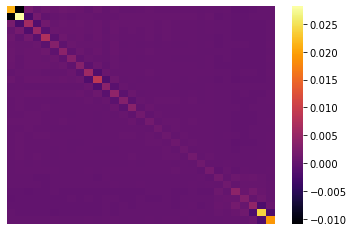

In [37]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
# plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

<AxesSubplot:>

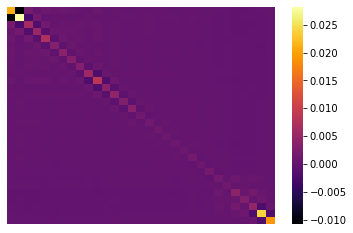

In [38]:
sns.heatmap(pd.DataFrame(syscov.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)


In [39]:
# np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")


In [40]:
# Guardar modelos
autoencoder.save('../models/autoencoderJLA.h5')
decoder.save('../models/decoderJLA.h5')
encoder.save('../models/encoderJLA.h5')

In [41]:
np.min(np.abs(syscov - decoded_fake[0, :].reshape(31,31)))

1.3105645832890006e-10

In [42]:
np.max(decoded_fake[0, :].reshape(31,31))

0.028147763

In [43]:
np.max(syscov)

0.02815552265

In [44]:
np.min(decoded_fake[0, :].reshape(31,31))

-0.010902207

In [45]:
np.min(np.abs(syscov))

1.695011341e-07